Инициализация модели...
Loads checkpoint by local backend from path: E:/Yandex_prakt/mmsegmentation/work_dirs/segformer_b0_custom/iter_7000.pth
Модель загружена на устройство: cpu

Найдено 119 тестовых изображений

Запуск инференса...


E:\Yandex_prakt\mmsegmentation\mmseg\models\losses\cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Обработано: 10/119
Обработано: 20/119
Обработано: 30/119
Обработано: 40/119
Обработано: 50/119
Обработано: 60/119
Обработано: 70/119
Обработано: 80/119
Обработано: 90/119
Обработано: 100/119
Обработано: 110/119

РЕЗУЛЬТАТЫ ИНФЕРЕНСА

Средний Dice на тесте: 0.7189 ± 0.1620
Средний IoU на тесте:  0.5762 ± 0.2113

Dice по классам:
  Class 0 (background): 0.9569
  Class 1 (cat):        0.4738
  Class 2 (dog):        0.4441

IoU по классам:
  Class 0 (background): 0.9185
  Class 1 (cat):        0.4225
  Class 2 (dog):        0.3876

Статистика Dice по изображениям:
  Min:  0.4529
  Max:  0.9566
  Med:  0.7603
  25%:  0.5300
  75%:  0.8602

МАТРИЦА ОШИБОК


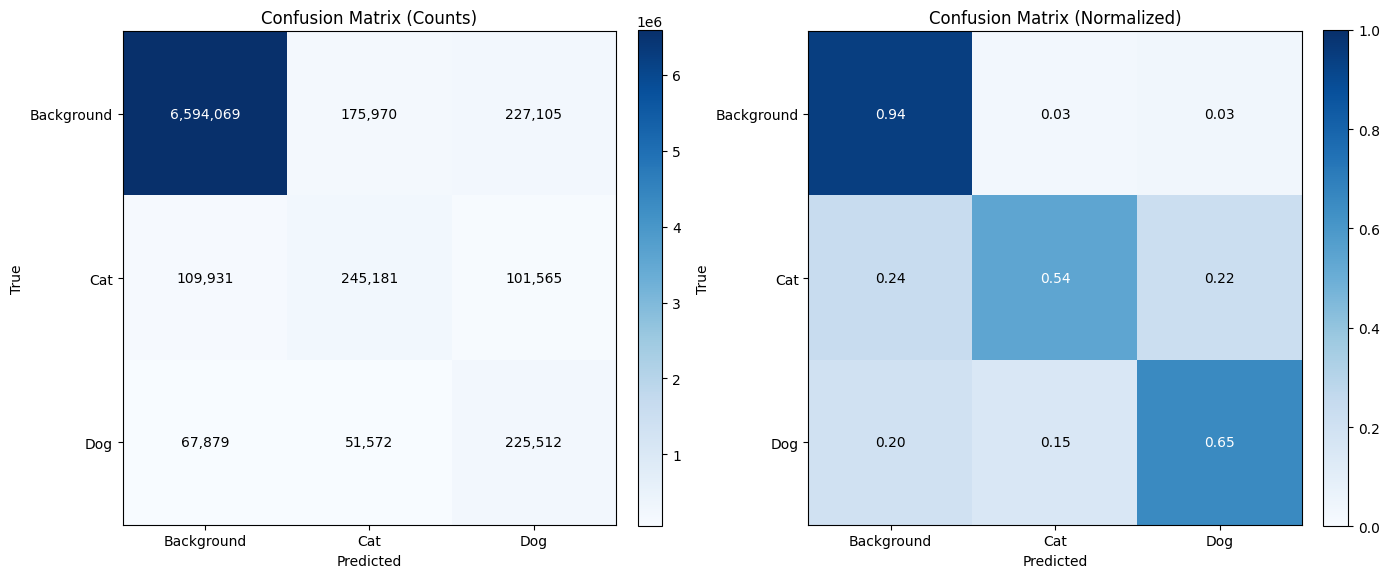


Матрица ошибок (абсолютные значения):
                Pred Background      Pred Cat        Pred Dog       
True Background 6,594,069       175,970         227,105        
True Cat        109,931         245,181         101,565        
True Dog        67,879          51,572          225,512        


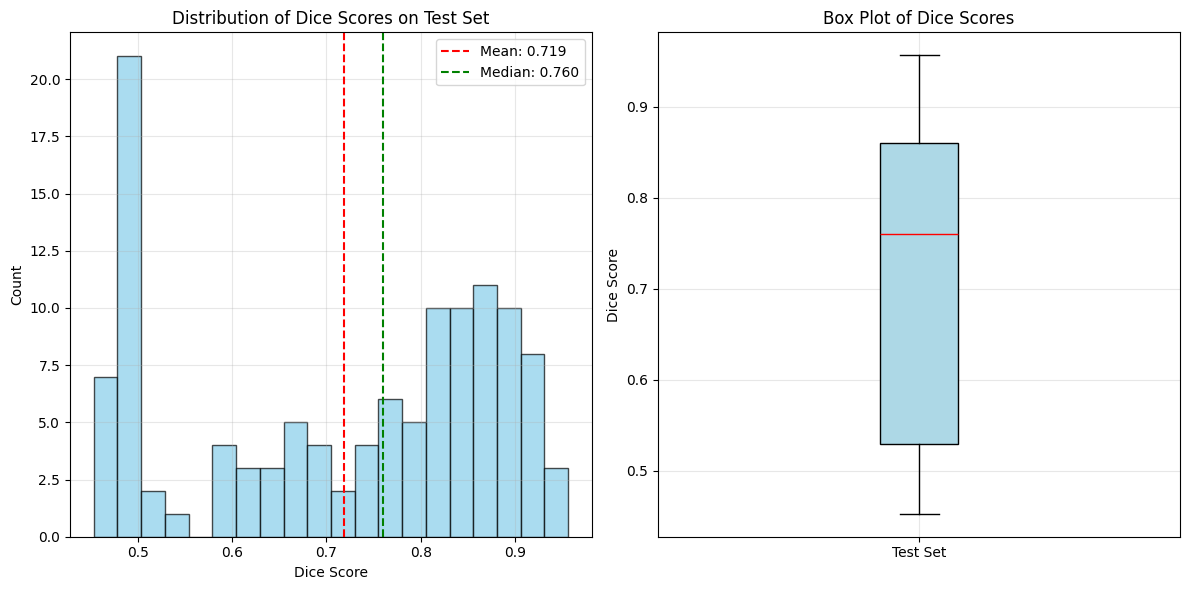

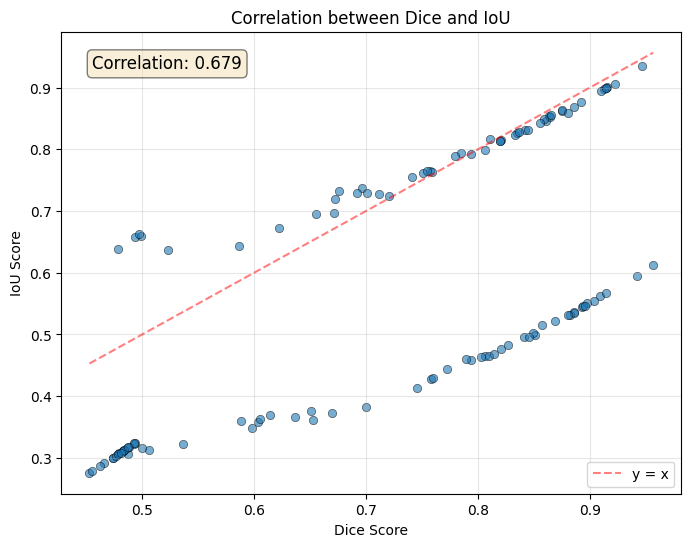


АНАЛИЗ ПРЕДСКАЗАНИЙ

1. ХУДШИЕ ПРЕДСКАЗАНИЯ (низкий Dice):
  - 000000406422_6565.jpg: Dice=0.453, IoU=0.276
  - 000000489944_1657.jpg: Dice=0.455, IoU=0.279
  - 000000485148_1904.jpg: Dice=0.462, IoU=0.287


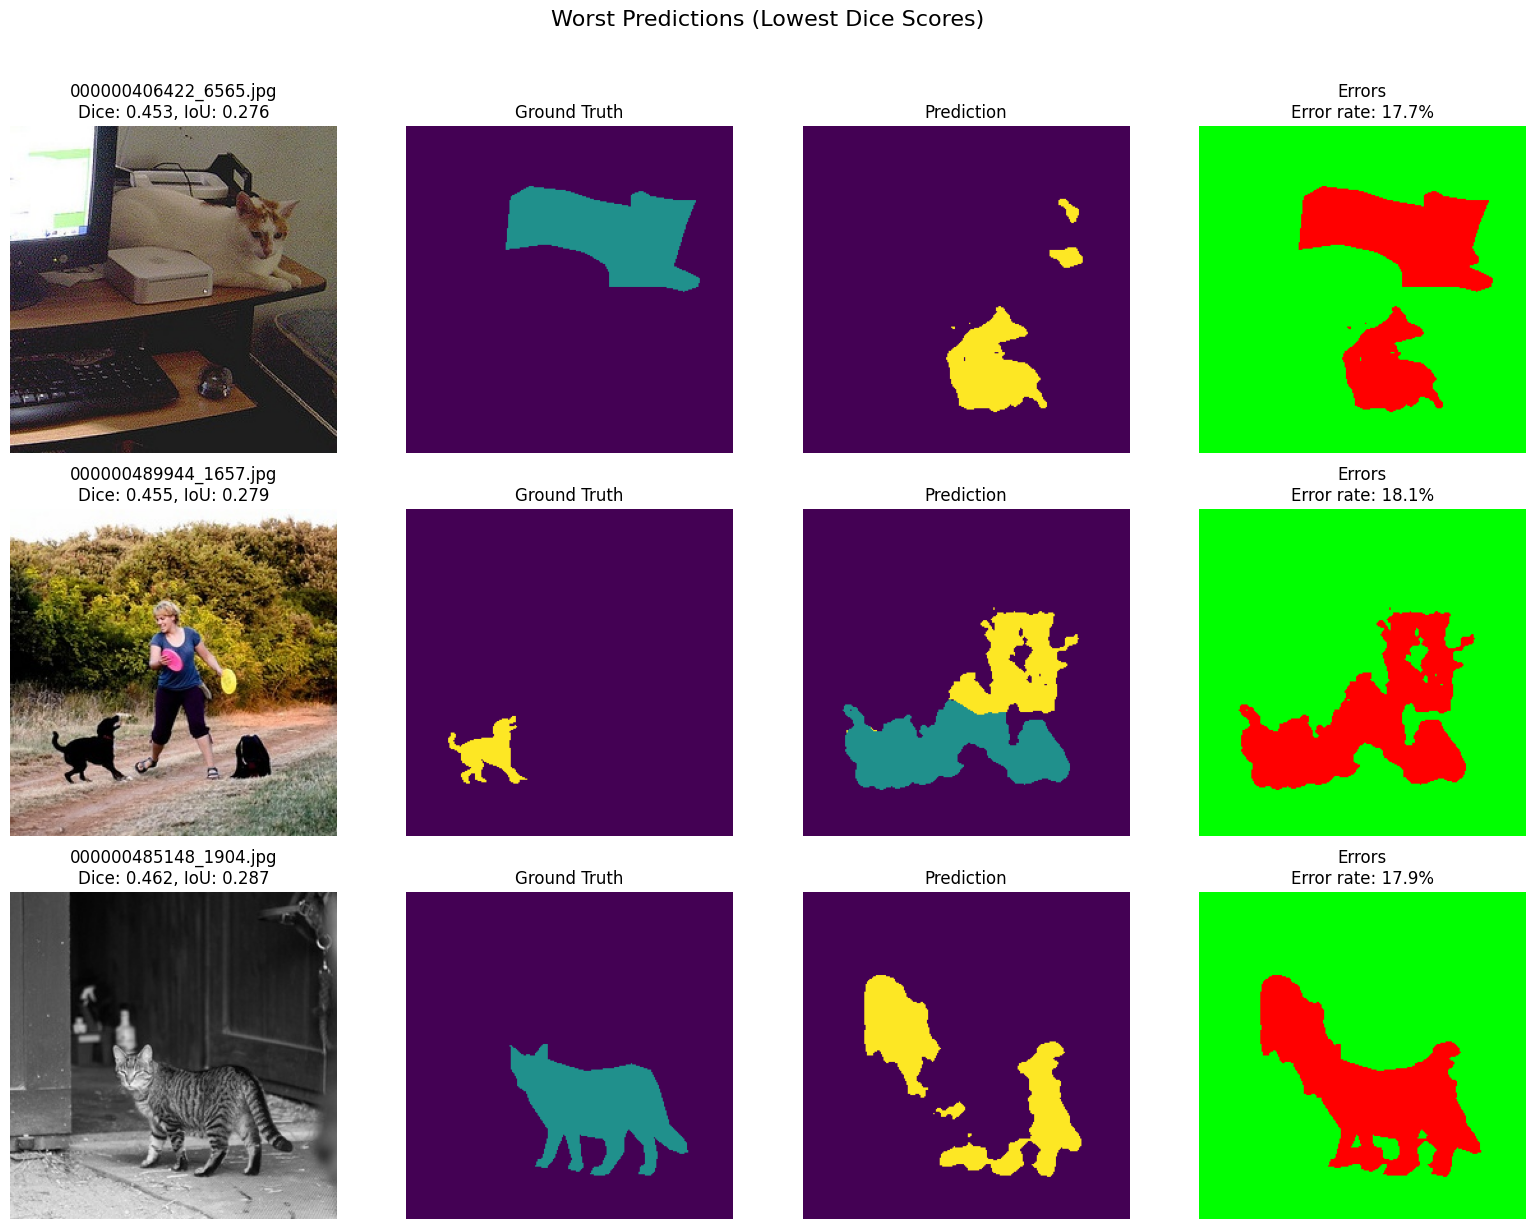


2. ЛУЧШИЕ ПРЕДСКАЗАНИЯ (высокий Dice):
  - 000000465591_1888.jpg: Dice=0.942, IoU=0.595
  - 000000408008_1937.jpg: Dice=0.947, IoU=0.934
  - 000000414495_3471.jpg: Dice=0.957, IoU=0.612


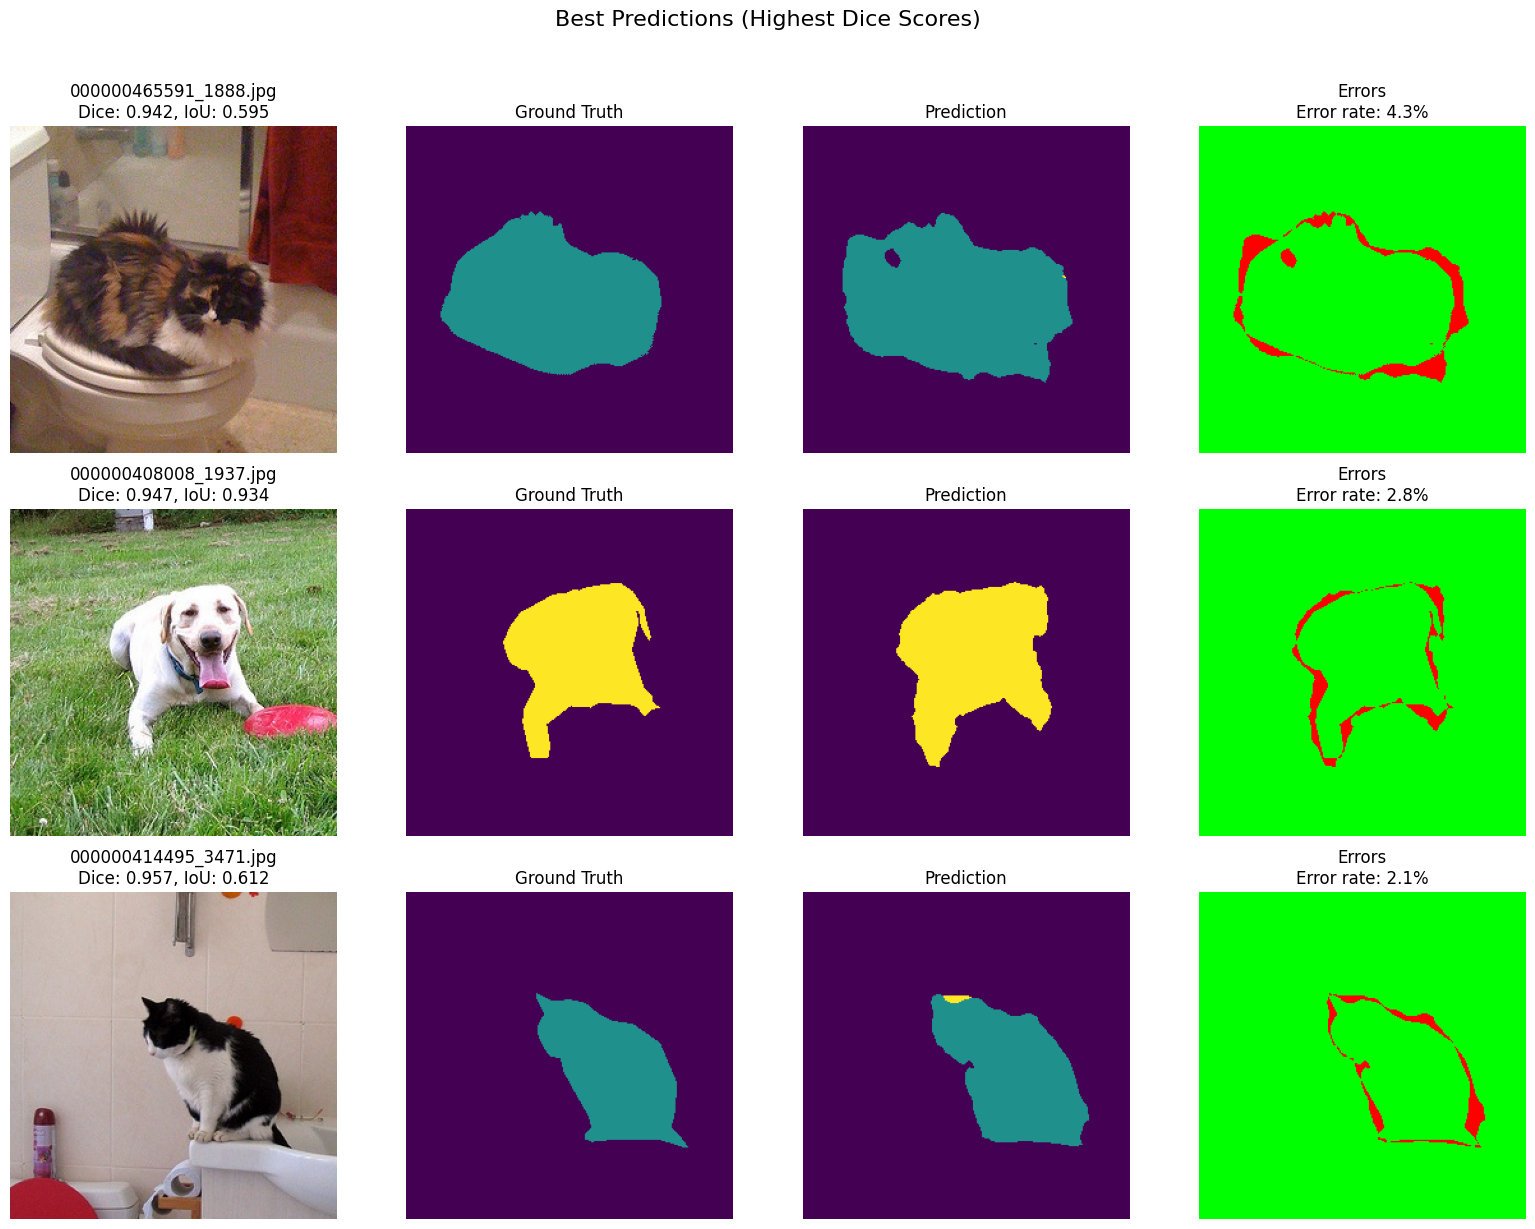


3. СЛУЧАЙНЫЕ ПРЕДСКАЗАНИЯ (средний Dice):
  - 000000260738_2306.jpg: Dice=0.794, IoU=0.459
  - 000000537213_6413.jpg: Dice=0.700, IoU=0.382
  - 000000376362_2504.jpg: Dice=0.772, IoU=0.445


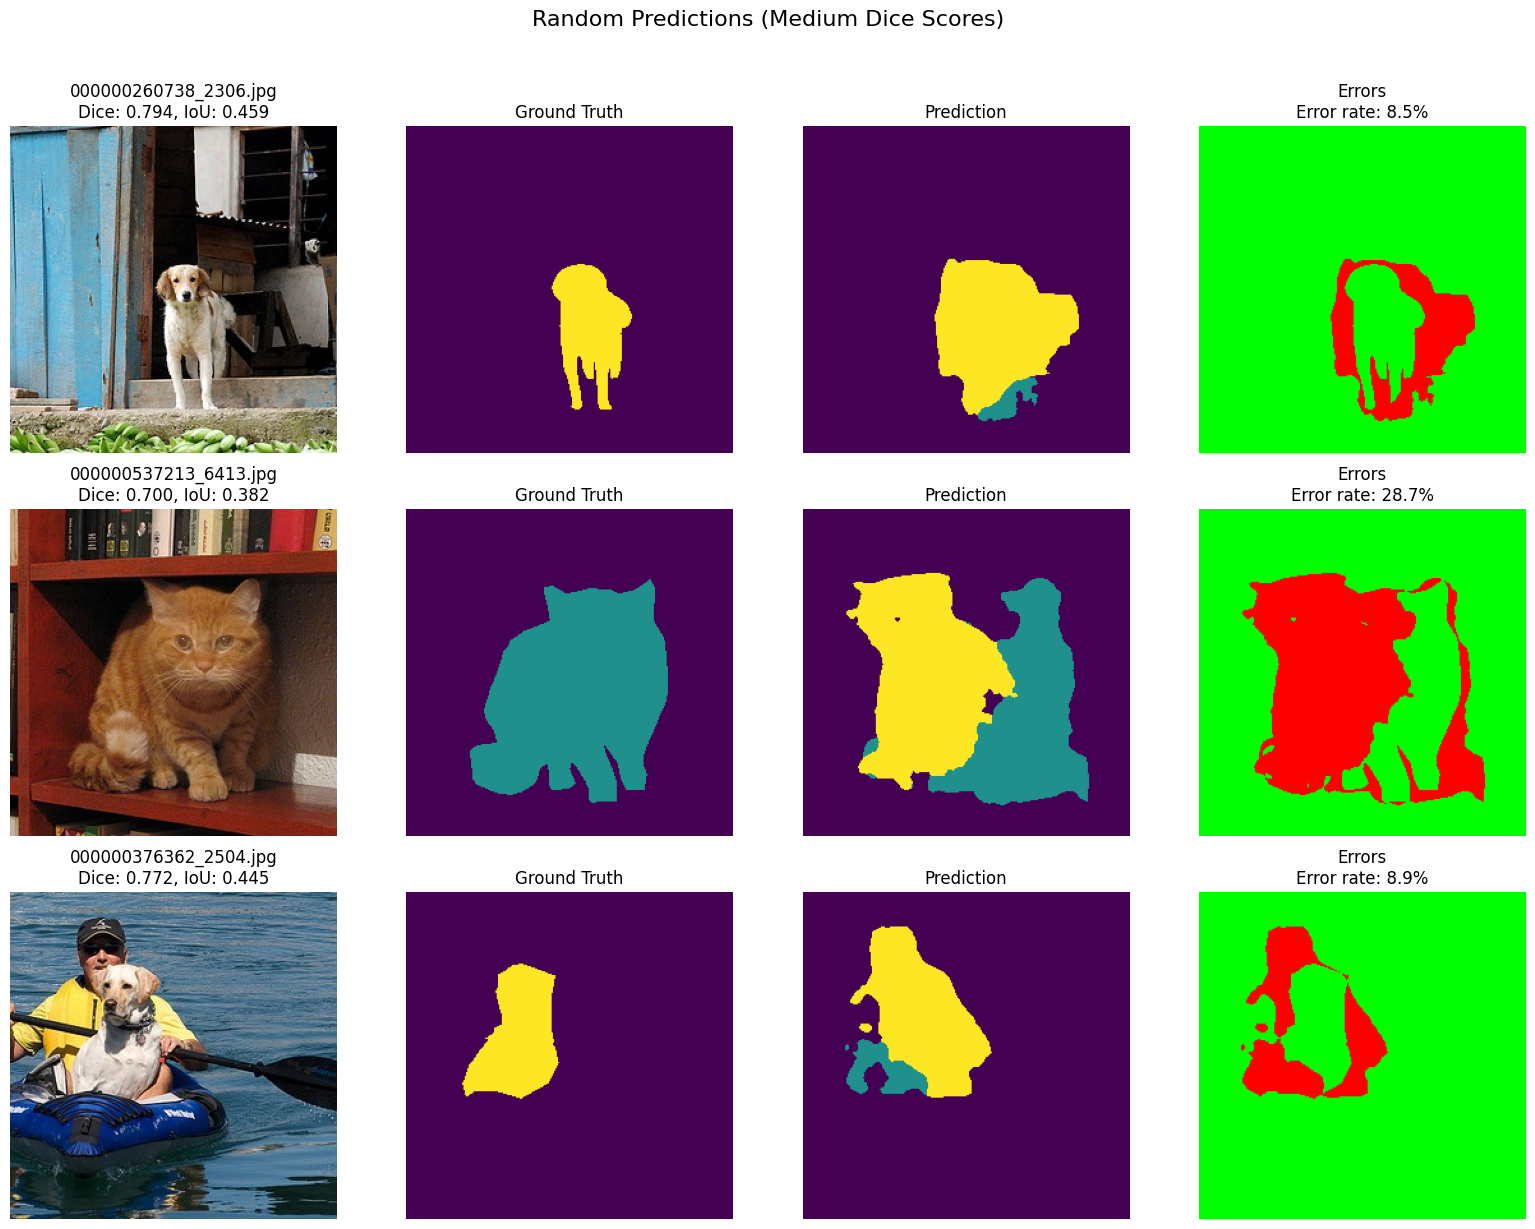


ДЕТАЛЬНЫЙ АНАЛИЗ ОШИБОК

Анализ изображения: 000000563342_7436.jpg
Dice: 0.7603
IoU:  0.4289
Размер: 256x256 пикселей
Всего пикселей: 65,536

Анализ по классам:

  Background:
    Dice: 0.9278
    IoU:  0.8652
    Predicted pixels: 52,104 (79.5%)
    GT pixels:        59,094 (90.2%)

  Cat:
    Dice: 0.5929
    IoU:  0.4213
    Predicted pixels: 6,603 (10.1%)
    GT pixels:        6,442 (9.8%)

  Dog:
    Dice: 0.0000
    IoU:  0.0000
    Predicted pixels: 6,829 (10.4%)
    GT pixels:        0 (0.0%)


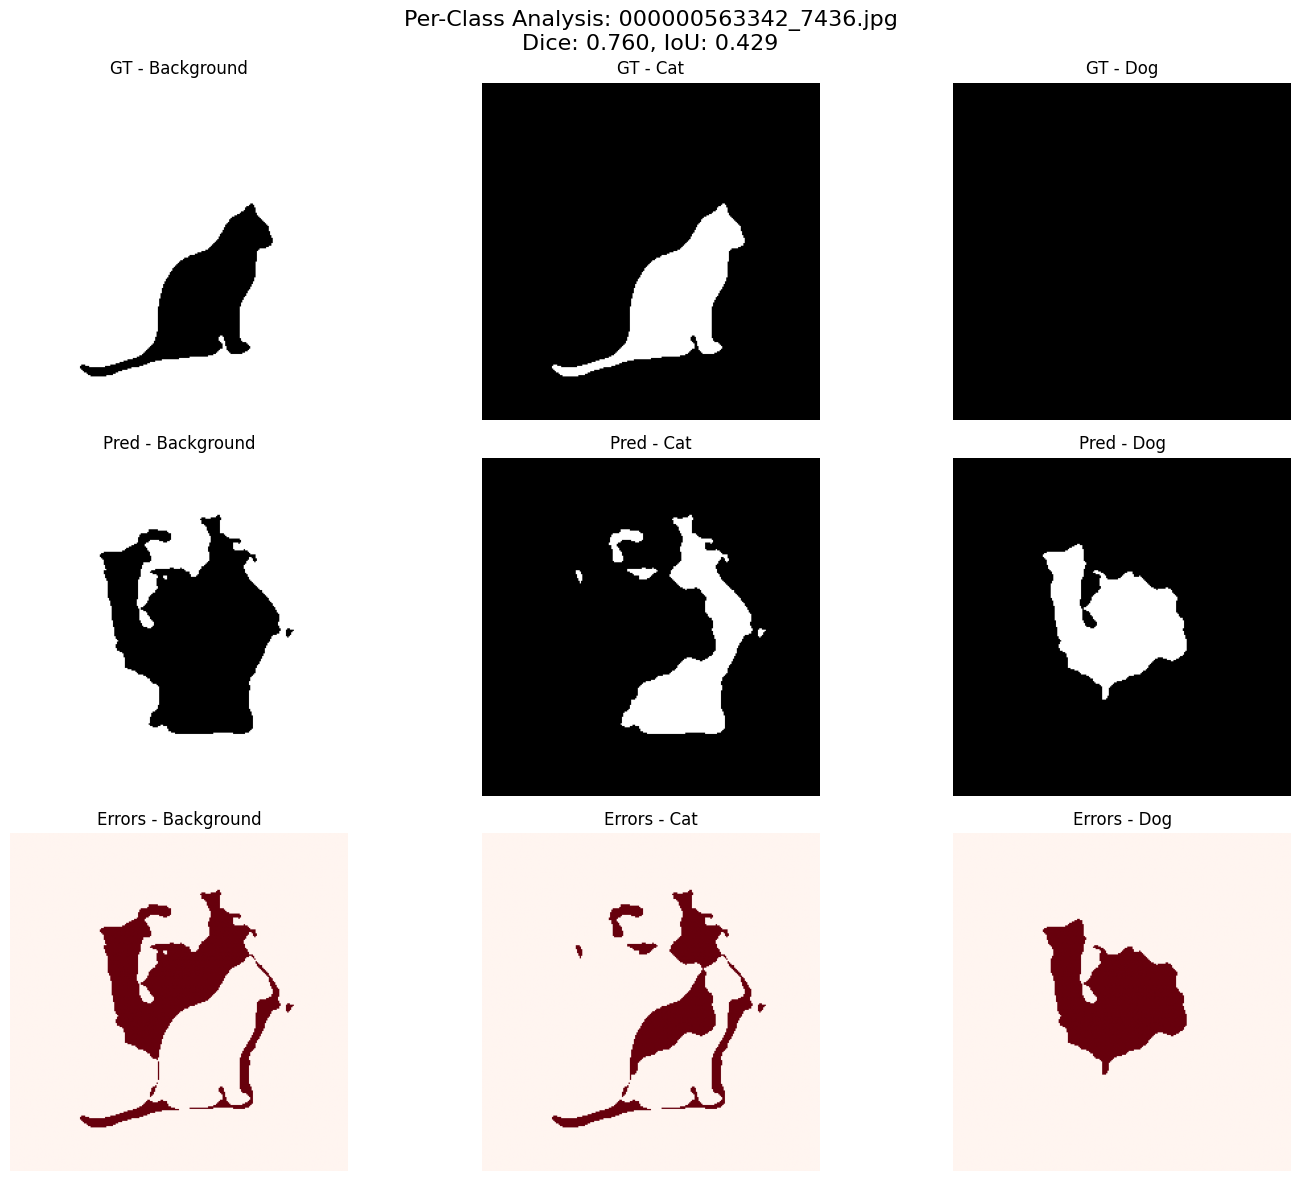


СОХРАНЕНИЕ РЕЗУЛЬТАТОВ

Результаты сохранены в папке: E:/Yandex_prakt/1_Proj_segment/inference_results1
  - inference_results.csv - детальные результаты по каждому изображению
  - summary_statistics.csv - сводная статистика
  - confusion_matrix.png - матрица ошибок
  - dice_distribution.png - распределение Dice scores
  - dice_iou_correlation.png - корреляция Dice и IoU
  - per_class_analysis.png - анализ по классам
  - worst_examples.png - худшие предсказания
  - best_examples.png - лучшие предсказания
  - random_examples.png - случайные предсказания

Готово!


In [6]:
import os
import torch
import mmcv
import numpy as np
import matplotlib.pyplot as plt
from mmseg.apis import init_model, inference_model
from mmseg.utils import register_all_modules
from mmengine.config import Config
import pandas as pd

# 1. Регистрация кастомных модулей
register_all_modules()

# 2. Пути к файлам
config_path = 'E:\\Yandex_prakt\\mmsegmentation\\configs\\segformer\\segformer_b0_custom.py'
checkpoint_path = 'E:/Yandex_prakt/mmsegmentation/work_dirs/segformer_b0_custom/iter_7000.pth'
test_img_dir = 'E:/Yandex_prakt/1_Proj_segment/stud_dataset/images/test'
test_ann_dir = 'E:/Yandex_prakt/1_Proj_segment/stud_dataset/annotations/test'
output_dir = 'E:/Yandex_prakt/1_Proj_segment/inference_results1'
os.makedirs(output_dir, exist_ok=True)

# 3. Инициализация модели
print("Инициализация модели...")
cfg = Config.fromfile(config_path)
model = init_model(cfg, checkpoint_path, device='cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Модель загружена на устройство: {next(model.parameters()).device}")

# 4. Функция для расчета Dice
def calculate_dice(pred, target, num_classes=3):
    """Расчет Dice для каждого класса"""
    dice_scores = {}
    for i in range(num_classes):
        p = (pred == i).astype(np.float32)
        t = (target == i).astype(np.float32)
        
        if t.sum() == 0 and p.sum() == 0:
            dice = 1.0  # Если оба пустые - идеальное совпадение
        elif t.sum() == 0:
            dice = 0.0  # Если нет GT, но есть предсказание
        else:
            intersection = np.sum(p * t)
            dice = (2. * intersection) / (p.sum() + t.sum() + 1e-6)
        
        dice_scores[f'class_{i}'] = dice
    
    # Средний Dice по классам, присутствующим в GT
    valid_classes = [i for i in range(num_classes) if (target == i).sum() > 0]
    if valid_classes:
        mean_dice = np.mean([dice_scores[f'class_{i}'] for i in valid_classes])
    else:
        mean_dice = 0.0
    
    return mean_dice, dice_scores

# 5. Функция для расчета IoU
def calculate_iou(pred, target, num_classes=3):
    """Расчет IoU для каждого класса"""
    iou_scores = {}
    for i in range(num_classes):
        p = (pred == i).astype(np.float32)
        t = (target == i).astype(np.float32)
        
        intersection = np.sum(p * t)
        union = np.sum(p + t) - intersection
        
        if union == 0:
            iou = 1.0 if intersection == 0 else 0.0
        else:
            iou = intersection / (union + 1e-6)
        
        iou_scores[f'class_{i}'] = iou
    
    # Средний IoU по классам
    mean_iou = np.mean(list(iou_scores.values()))
    return mean_iou, iou_scores

# 6. Функция для расчета матрицы ошибок
def calculate_confusion_matrix(pred, target, num_classes=3):
    """Расчет confusion matrix"""
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)
    
    for i in range(num_classes):
        for j in range(num_classes):
            cm[i, j] = np.sum((target == i) & (pred == j))
    
    return cm

# 7. Загрузка тестовых данных
image_files = [f for f in os.listdir(test_img_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
print(f"\nНайдено {len(image_files)} тестовых изображений")

# 8. Инференс и сбор результатов
results = []
all_preds = []
all_targets = []
class_names = ['Background', 'Cat', 'Dog']

print("\nЗапуск инференса...")
for idx, img_name in enumerate(image_files):
    img_path = os.path.join(test_img_dir, img_name)
    ann_path = os.path.join(test_ann_dir, os.path.splitext(img_name)[0] + '.png')
    
    if not os.path.exists(ann_path):
        print(f"Внимание: нет разметки для {img_name}")
        continue
    
    # Инференс
    result = inference_model(model, img_path)
    pred_mask = result.pred_sem_seg.data[0].cpu().numpy()
    
    # Загрузка GT маски
    gt_mask = mmcv.imread(ann_path, flag='unchanged')
    if len(gt_mask.shape) == 3:
        gt_mask = gt_mask[:, :, 0]
    
    # Расчет метрик
    dice_score, dice_by_class = calculate_dice(pred_mask, gt_mask)
    iou_score, iou_by_class = calculate_iou(pred_mask, gt_mask)
    
    # Сбор данных для матрицы ошибок
    all_preds.append(pred_mask.flatten())
    all_targets.append(gt_mask.flatten())
    
    # Информация о распределении пикселей
    height, width = gt_mask.shape
    total_pixels = height * width
    
    results.append({
        'name': img_name,
        'dice': dice_score,
        'iou': iou_score,
        'dice_by_class': dice_by_class,
        'iou_by_class': iou_by_class,
        'img': mmcv.imread(img_path),
        'pred': pred_mask,
        'gt': gt_mask,
        'pred_pixels': {class_names[i]: (pred_mask == i).sum() for i in range(3)},
        'gt_pixels': {class_names[i]: (gt_mask == i).sum() for i in range(3)},
        'total_pixels': total_pixels
    })
    
    if (idx + 1) % 10 == 0:
        print(f"Обработано: {idx + 1}/{len(image_files)}")

# 9. Общая статистика
print("\n" + "="*50)
print("РЕЗУЛЬТАТЫ ИНФЕРЕНСА")
print("="*50)

# Средние метрики
all_dice = [r['dice'] for r in results]
all_iou = [r['iou'] for r in results]

print(f"\nСредний Dice на тесте: {np.mean(all_dice):.4f} ± {np.std(all_dice):.4f}")
print(f"Средний IoU на тесте:  {np.mean(all_iou):.4f} ± {np.std(all_iou):.4f}")

# Dice по классам
dice_class_0 = np.mean([r['dice_by_class']['class_0'] for r in results])
dice_class_1 = np.mean([r['dice_by_class']['class_1'] for r in results])
dice_class_2 = np.mean([r['dice_by_class']['class_2'] for r in results])

print(f"\nDice по классам:")
print(f"  Class 0 (background): {dice_class_0:.4f}")
print(f"  Class 1 (cat):        {dice_class_1:.4f}")
print(f"  Class 2 (dog):        {dice_class_2:.4f}")

# IoU по классам
iou_class_0 = np.mean([r['iou_by_class']['class_0'] for r in results])
iou_class_1 = np.mean([r['iou_by_class']['class_1'] for r in results])
iou_class_2 = np.mean([r['iou_by_class']['class_2'] for r in results])

print(f"\nIoU по классам:")
print(f"  Class 0 (background): {iou_class_0:.4f}")
print(f"  Class 1 (cat):        {iou_class_1:.4f}")
print(f"  Class 2 (dog):        {iou_class_2:.4f}")

# Статистика по изображениям
results_df = pd.DataFrame(results)
print(f"\nСтатистика Dice по изображениям:")
print(f"  Min:  {results_df['dice'].min():.4f}")
print(f"  Max:  {results_df['dice'].max():.4f}")
print(f"  Med:  {results_df['dice'].median():.4f}")
print(f"  25%:  {results_df['dice'].quantile(0.25):.4f}")
print(f"  75%:  {results_df['dice'].quantile(0.75):.4f}")

# 10. Матрица ошибок
print("\n" + "="*50)
print("МАТРИЦА ОШИБОК")
print("="*50)

# Объединяем все предсказания и GT
all_preds_flat = np.concatenate(all_preds)
all_targets_flat = np.concatenate(all_targets)

cm = calculate_confusion_matrix(all_preds_flat, all_targets_flat)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Визуализация матрицы ошибок
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Матрица в абсолютных значениях
im1 = axes[0].imshow(cm, cmap='Blues')
axes[0].set_title('Confusion Matrix (Counts)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_xticks([0, 1, 2])
axes[0].set_yticks([0, 1, 2])
axes[0].set_xticklabels(class_names)
axes[0].set_yticklabels(class_names)

# Добавление значений в ячейки
for i in range(3):
    for j in range(3):
        text = axes[0].text(j, i, f'{cm[i, j]:,}',
                          ha="center", va="center", 
                          color="white" if cm[i, j] > cm.max()/2 else "black")

# Нормализованная матрица
im2 = axes[1].imshow(cm_normalized, cmap='Blues', vmin=0, vmax=1)
axes[1].set_title('Confusion Matrix (Normalized)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_xticks([0, 1, 2])
axes[1].set_yticks([0, 1, 2])
axes[1].set_xticklabels(class_names)
axes[1].set_yticklabels(class_names)

# Добавление значений в ячейки
for i in range(3):
    for j in range(3):
        text = axes[1].text(j, i, f'{cm_normalized[i, j]:.2f}',
                          ha="center", va="center", 
                          color="white" if cm_normalized[i, j] > 0.5 else "black")

plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'), dpi=150, bbox_inches='tight')
plt.show()

# Вывод информации о матрице
print("\nМатрица ошибок (абсолютные значения):")
print(f"{'':<15} {'Pred Background':<20} {'Pred Cat':<15} {'Pred Dog':<15}")
for i, true_class in enumerate(class_names):
    row = f"{'True ' + true_class:<15}"
    for j in range(3):
        row += f" {cm[i, j]:<15,}"
    print(row)

# 11. Распределение Dice scores
plt.figure(figsize=(12, 6))

# Гистограмма
plt.subplot(1, 2, 1)
plt.hist(all_dice, bins=20, edgecolor='black', alpha=0.7, color='skyblue')
plt.axvline(np.mean(all_dice), color='red', linestyle='--', 
           label=f'Mean: {np.mean(all_dice):.3f}')
plt.axvline(np.median(all_dice), color='green', linestyle='--',
           label=f'Median: {np.median(all_dice):.3f}')
plt.xlabel('Dice Score')
plt.ylabel('Count')
plt.title('Distribution of Dice Scores on Test Set')
plt.legend()
plt.grid(True, alpha=0.3)

# Box plot
plt.subplot(1, 2, 2)
plt.boxplot(all_dice, vert=True, patch_artist=True,
           boxprops=dict(facecolor='lightblue'),
           medianprops=dict(color='red'))
plt.ylabel('Dice Score')
plt.title('Box Plot of Dice Scores')
plt.grid(True, alpha=0.3)
plt.xticks([1], ['Test Set'])

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'dice_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

# 12. Корреляция Dice и IoU
plt.figure(figsize=(8, 6))
plt.scatter(all_dice, all_iou, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.xlabel('Dice Score')
plt.ylabel('IoU Score')
plt.title('Correlation between Dice and IoU')
plt.grid(True, alpha=0.3)

# Линия идеальной корреляции
x_line = np.linspace(min(all_dice), max(all_dice), 100)
plt.plot(x_line, x_line, 'r--', alpha=0.5, label='y = x')

# Коэффициент корреляции
correlation = np.corrcoef(all_dice, all_iou)[0, 1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
         transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.legend()
plt.savefig(os.path.join(output_dir, 'dice_iou_correlation.png'), dpi=150, bbox_inches='tight')
plt.show()

# 13. Примеры корректных и некорректных предсказаний
print("\n" + "="*50)
print("АНАЛИЗ ПРЕДСКАЗАНИЙ")
print("="*50)

# Сортировка по Dice
results_sorted = sorted(results, key=lambda x: x['dice'])

# Выбор примеров
worst_examples = results_sorted[:3]  # 3 худших
best_examples = results_sorted[-3:]   # 3 лучших

# Случайные примеры из среднего диапазона
middle_start = len(results_sorted) // 4
middle_end = 3 * len(results_sorted) // 4
middle_indices = np.random.choice(range(middle_start, middle_end), 3, replace=False)
random_examples = [results_sorted[i] for i in middle_indices]

def plot_examples(examples, title, save_prefix):
    """Визуализация нескольких примеров"""
    fig, axes = plt.subplots(len(examples), 4, figsize=(16, 4*len(examples)))
    if len(examples) == 1:
        axes = [axes]
    
    for idx, (ax_row, data) in enumerate(zip(axes, examples)):
        # Оригинальное изображение
        ax_row[0].imshow(mmcv.bgr2rgb(data['img']))
        ax_row[0].set_title(f"{data['name']}\nDice: {data['dice']:.3f}, IoU: {data['iou']:.3f}")
        ax_row[0].axis('off')
        
        # GT маска
        ax_row[1].imshow(data['gt'], cmap='viridis', vmin=0, vmax=2)
        ax_row[1].set_title("Ground Truth")
        ax_row[1].axis('off')
        
        # Предсказанная маска
        ax_row[2].imshow(data['pred'], cmap='viridis', vmin=0, vmax=2)
        ax_row[2].set_title("Prediction")
        ax_row[2].axis('off')
        
        # Разница (ошибки)
        diff = np.zeros((*data['gt'].shape, 3), dtype=np.uint8)
        # Зеленый = правильные предсказания
        correct = (data['pred'] == data['gt'])
        diff[correct] = [0, 255, 0]
        # Красный = ошибки
        diff[~correct] = [255, 0, 0]
        
        # Процент ошибок
        error_rate = np.sum(~correct) / data['total_pixels'] * 100
        
        ax_row[3].imshow(diff)
        ax_row[3].set_title(f"Errors\nError rate: {error_rate:.1f}%")
        ax_row[3].axis('off')
    
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{save_prefix}_examples.png'), 
                dpi=150, bbox_inches='tight')
    plt.show()

# Визуализация примеров
print("\n1. ХУДШИЕ ПРЕДСКАЗАНИЯ (низкий Dice):")
for ex in worst_examples:
    print(f"  - {ex['name']}: Dice={ex['dice']:.3f}, IoU={ex['iou']:.3f}")
plot_examples(worst_examples, "Worst Predictions (Lowest Dice Scores)", "worst")

print("\n2. ЛУЧШИЕ ПРЕДСКАЗАНИЯ (высокий Dice):")
for ex in best_examples:
    print(f"  - {ex['name']}: Dice={ex['dice']:.3f}, IoU={ex['iou']:.3f}")
plot_examples(best_examples, "Best Predictions (Highest Dice Scores)", "best")

print("\n3. СЛУЧАЙНЫЕ ПРЕДСКАЗАНИЯ (средний Dice):")
for ex in random_examples:
    print(f"  - {ex['name']}: Dice={ex['dice']:.3f}, IoU={ex['iou']:.3f}")
plot_examples(random_examples, "Random Predictions (Medium Dice Scores)", "random")

# 14. Детальный анализ ошибок для одного примера
print("\n" + "="*50)
print("ДЕТАЛЬНЫЙ АНАЛИЗ ОШИБОК")
print("="*50)

# Берем средний по качеству пример
middle_idx = len(results_sorted) // 2
sample = results_sorted[middle_idx]

print(f"\nАнализ изображения: {sample['name']}")
print(f"Dice: {sample['dice']:.4f}")
print(f"IoU:  {sample['iou']:.4f}")
print(f"Размер: {sample['gt'].shape[0]}x{sample['gt'].shape[1]} пикселей")
print(f"Всего пикселей: {sample['total_pixels']:,}")

# Анализ по классам
print("\nАнализ по классам:")
for class_idx, class_name in enumerate(class_names):
    dice_val = sample['dice_by_class'][f'class_{class_idx}']
    iou_val = sample['iou_by_class'][f'class_{class_idx}']
    pred_pixels = sample['pred_pixels'][class_name]
    gt_pixels = sample['gt_pixels'][class_name]
    
    print(f"\n  {class_name}:")
    print(f"    Dice: {dice_val:.4f}")
    print(f"    IoU:  {iou_val:.4f}")
    print(f"    Predicted pixels: {pred_pixels:,} ({pred_pixels/sample['total_pixels']*100:.1f}%)")
    print(f"    GT pixels:        {gt_pixels:,} ({gt_pixels/sample['total_pixels']*100:.1f}%)")

# Визуализация каждого класса отдельно
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

for class_idx in range(3):
    class_name = class_names[class_idx]
    
    # GT для класса
    gt_class = (sample['gt'] == class_idx).astype(np.uint8)
    axes[0, class_idx].imshow(gt_class, cmap='gray')
    axes[0, class_idx].set_title(f"GT - {class_name}")
    axes[0, class_idx].axis('off')
    
    # Pred для класса
    pred_class = (sample['pred'] == class_idx).astype(np.uint8)
    axes[1, class_idx].imshow(pred_class, cmap='gray')
    axes[1, class_idx].set_title(f"Pred - {class_name}")
    axes[1, class_idx].axis('off')
    
    # Ошибки для класса
    errors = ((sample['pred'] == class_idx) != (sample['gt'] == class_idx)).astype(np.uint8)
    axes[2, class_idx].imshow(errors, cmap='Reds')
    axes[2, class_idx].set_title(f"Errors - {class_name}")
    axes[2, class_idx].axis('off')

plt.suptitle(f"Per-Class Analysis: {sample['name']}\nDice: {sample['dice']:.3f}, IoU: {sample['iou']:.3f}", fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'per_class_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

# 15. Сохранение результатов в CSV
print("\n" + "="*50)
print("СОХРАНЕНИЕ РЕЗУЛЬТАТОВ")
print("="*50)

# Подготовка данных для CSV
csv_data = []
for r in results:
    row = {
        'image_name': r['name'],
        'dice': r['dice'],
        'iou': r['iou'],
        'dice_background': r['dice_by_class']['class_0'],
        'dice_cat': r['dice_by_class']['class_1'],
        'dice_dog': r['dice_by_class']['class_2'],
        'iou_background': r['iou_by_class']['class_0'],
        'iou_cat': r['iou_by_class']['class_1'],
        'iou_dog': r['iou_by_class']['class_2'],
        'gt_background_pixels': r['gt_pixels']['Background'],
        'gt_cat_pixels': r['gt_pixels']['Cat'],
        'gt_dog_pixels': r['gt_pixels']['Dog'],
        'pred_background_pixels': r['pred_pixels']['Background'],
        'pred_cat_pixels': r['pred_pixels']['Cat'],
        'pred_dog_pixels': r['pred_pixels']['Dog'],
        'total_pixels': r['total_pixels']
    }
    csv_data.append(row)

df_results = pd.DataFrame(csv_data)
df_results.to_csv(os.path.join(output_dir, 'inference_results.csv'), index=False)

# Сводная статистика
summary_stats = {
    'metric': ['mDice', 'mIoU', 'Dice Background', 'Dice Cat', 'Dice Dog',
               'IoU Background', 'IoU Cat', 'IoU Dog'],
    'mean': [np.mean(all_dice), np.mean(all_iou), dice_class_0, dice_class_1, dice_class_2,
             iou_class_0, iou_class_1, iou_class_2],
    'std': [np.std(all_dice), np.std(all_iou),
            np.std([r['dice_by_class']['class_0'] for r in results]),
            np.std([r['dice_by_class']['class_1'] for r in results]),
            np.std([r['dice_by_class']['class_2'] for r in results]),
            np.std([r['iou_by_class']['class_0'] for r in results]),
            np.std([r['iou_by_class']['class_1'] for r in results]),
            np.std([r['iou_by_class']['class_2'] for r in results])],
    'min': [min(all_dice), min(all_iou),
            min([r['dice_by_class']['class_0'] for r in results]),
            min([r['dice_by_class']['class_1'] for r in results]),
            min([r['dice_by_class']['class_2'] for r in results]),
            min([r['iou_by_class']['class_0'] for r in results]),
            min([r['iou_by_class']['class_1'] for r in results]),
            min([r['iou_by_class']['class_2'] for r in results])],
    'max': [max(all_dice), max(all_iou),
            max([r['dice_by_class']['class_0'] for r in results]),
            max([r['dice_by_class']['class_1'] for r in results]),
            max([r['dice_by_class']['class_2'] for r in results]),
            max([r['iou_by_class']['class_0'] for r in results]),
            max([r['iou_by_class']['class_1'] for r in results]),
            max([r['iou_by_class']['class_2'] for r in results])]
}

df_summary = pd.DataFrame(summary_stats)
df_summary.to_csv(os.path.join(output_dir, 'summary_statistics.csv'), index=False)

print(f"\nРезультаты сохранены в папке: {output_dir}")
print(f"  - inference_results.csv - детальные результаты по каждому изображению")
print(f"  - summary_statistics.csv - сводная статистика")
print(f"  - confusion_matrix.png - матрица ошибок")
print(f"  - dice_distribution.png - распределение Dice scores")
print(f"  - dice_iou_correlation.png - корреляция Dice и IoU")
print(f"  - per_class_analysis.png - анализ по классам")
print(f"  - worst_examples.png - худшие предсказания")
print(f"  - best_examples.png - лучшие предсказания")
print(f"  - random_examples.png - случайные предсказания")

print("\nГотово!")